# Phase 2: Trajectory Prediction with Auxiliary Depth Estimation

# 🧭 Introduction

"""
Welcome to **Phase 2** of the DLAV Projec! 🚗💨

In this phase, you'll work with a more challenging dataset that includes:
- RGB **camera images**
- Ground-truth **depth maps**
- Ground-truth **semantic segmentation** labels

Your goal is still to predict the **future trajectory** of the self-driving car (SDC), but you now have more tools at your disposal! 🎯

Here, we provide an example where **depth estimation** is used as an auxiliary task to improve trajectory prediction.

However, you're **free to explore** other auxiliary tasks (e.g., using semantic labels), different loss functions, data augmentations, or better architectures! 💡

This notebook will walk you through loading the dataset, building a model, training with and without the auxiliary task, and visualizing results.
"""

In [1]:
# Install gdown to handle Google Drive file download
!pip install -q gdown
import os
import gdown
import zipfile


output_dir = os.path.join("data", "phase2")
if not os.path.exists(output_dir):  # Check if the directory already exists
    os.makedirs(output_dir)  # Create the directory if it doesn't exist

# Download the train dataset
download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = os.path.join(output_dir, "dlav_train.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "train")):  # Check if the directory already exists    
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

# Download the validation dataset
download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = os.path.join(output_dir, "dlav_val.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "val")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

# Download the test dataset
download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = os.path.join(output_dir, "dlav_test_public.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "test_public")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

## 📂 The Dataset

We are now working with a richer dataset that includes not just images and trajectories,
but also **depth maps** (and semantic segmentation labels, though unused in this example).

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict
- `depth`: ground truth depth map (shape: H x W x 1)

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

In [2]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import csv
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])

        depth = torch.FloatTensor(data['depth'])

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'future': future
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'depth': depth
            }

## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

This auxiliary task is enabled by setting `use_depth_aux=True`.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DrivingPlanner(nn.Module):
    def __init__(self, use_depth_aux=False):
        super().__init__()
        self.use_depth_aux = use_depth_aux

        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )

        self.cnn_flatten = nn.Flatten()


        # Decoder for trajectory prediction
        self.decoder = nn.Linear((32 * 100 * 150) + (21 * 3), 60 * 3)

        # Optional depth decoder
        if self.use_depth_aux:
            self.depth_decoder = nn.Sequential(
                nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # Upsample
                nn.ReLU(),
                nn.Conv2d(16, 1, kernel_size=3, padding=1),
                nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)
            )

    def forward(self, camera, history):
        B = camera.size(0)

        # Process camera
        cnn_feat = self.cnn_backbone(camera)         # (B, 32, 100, 150)
        feat_flat = self.cnn_flatten(cnn_feat)       # (B, 32*100*150)


        # Flatten history
        history_flat = history.view(B, -1)

        # Concatenate and decode trajectory
        combined = torch.cat([feat_flat, history_flat], dim=1)
        future = self.decoder(combined).view(B, 60, 3)

        # Optional depth map prediction
        depth_out = None
        if self.use_depth_aux:
            depth_out = self.depth_decoder(cnn_feat.detach()).permute(0, 2, 3, 1)

        return future, depth_out


## 🏋️ Training with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

Total loss = `trajectory_loss + lambda * depth_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!

In [4]:
import torch
import torch.nn.functional as F

def train_one_epoch(model, train_loader, optimizer, device, lambda_depth=0.1, use_depth_aux=False):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        cam, hist, fut, dep = [batch[k].to(device) for k in ['camera', 'history', 'future', 'depth']]
        optimizer.zero_grad()
        fut_pred, dep_pred = model(cam, hist)

        traj_loss = F.mse_loss(fut_pred, fut)
        loss = traj_loss
        if use_depth_aux:
            loss += lambda_depth * F.l1_loss(dep_pred, dep)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, device):
    model.eval()
    total_ade, total_fde, total_mse = 0.0, 0.0, 0.0
    count = 0

    with torch.no_grad():
        for batch in val_loader:
            cam = batch['camera'].to(device)
            hist = batch['history'].to(device)
            fut = batch['future'].to(device)

            fut_pred, _ = model(cam, hist)

            B, T, _ = fut.shape
            count += B

            ade = torch.norm(fut_pred[:, :, :2] - fut[:, :, :2], dim=2).mean(dim=1).sum()
            fde = torch.norm(fut_pred[:, -1, :2] - fut[:, -1, :2], dim=1).sum()
            mse = F.mse_loss(fut_pred, fut, reduction='sum')

            total_ade += ade.item()
            total_fde += fde.item()
            total_mse += mse.item()

    ade_avg = total_ade / count
    fde_avg = total_fde / count
    mse_avg = total_mse / (count * T * 3)

    return ade_avg, fde_avg, mse_avg

def train(model, train_loader, val_loader, optimizer, num_epochs=50, lambda_depth=0.1, use_depth_aux=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, lambda_depth, use_depth_aux)
        ade, fde, mse = validate(model, val_loader, device)

        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Validation - ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")


In [5]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = os.path.join("data", "phase2", "train")
val_data_dir = os.path.join("data", "phase2", "val")

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


## 🔍 Let's Compare Two Settings

We'll now train and evaluate the model in **two modes**:

1. **Without auxiliary task** — the model only predicts the trajectory.
2. **With depth auxiliary task** — the model also predicts a depth map, which helps it learn better visual features.

By comparing the results (ADE, FDE, and Trajectory MSE), you'll see the benefit of multi-task learning in action! 🚀

In [6]:
use_depth_aux=False
model_no_aux = DrivingPlanner(use_depth_aux=use_depth_aux)
optimizer = optim.Adam(model_no_aux.parameters(), lr=1e-3)
train(model_no_aux, train_loader, val_loader, optimizer, num_epochs=50,use_depth_aux=use_depth_aux)

Using device: cuda
Epoch 1, Loss: 90.0889, Validation - ADE: 5.4466, FDE: 13.6400, Traj MSE: 20.183010
Epoch 2, Loss: 14.5813, Validation - ADE: 3.9901, FDE: 10.4046, Traj MSE: 12.316786
Epoch 3, Loss: 10.8105, Validation - ADE: 3.7253, FDE: 9.4419, Traj MSE: 11.035479
Epoch 4, Loss: 9.3980, Validation - ADE: 3.5876, FDE: 8.9698, Traj MSE: 10.377532
Epoch 5, Loss: 8.0274, Validation - ADE: 3.6742, FDE: 8.9259, Traj MSE: 10.442392
Epoch 6, Loss: 6.8049, Validation - ADE: 3.7623, FDE: 9.1650, Traj MSE: 10.767478
Epoch 7, Loss: 6.0736, Validation - ADE: 3.8568, FDE: 9.1125, Traj MSE: 11.134714
Epoch 8, Loss: 5.0206, Validation - ADE: 3.8657, FDE: 8.9877, Traj MSE: 11.081071
Epoch 9, Loss: 4.3578, Validation - ADE: 3.8653, FDE: 9.2013, Traj MSE: 11.265766
Epoch 10, Loss: 3.7673, Validation - ADE: 3.9256, FDE: 9.1846, Traj MSE: 11.310717
Epoch 11, Loss: 3.3014, Validation - ADE: 3.8925, FDE: 9.1614, Traj MSE: 11.190955
Epoch 12, Loss: 2.8965, Validation - ADE: 4.0130, FDE: 9.2355, Traj MSE:

In [8]:
use_depth_aux=True
model_with_aux = DrivingPlanner(use_depth_aux=use_depth_aux)
optimizer = optim.Adam(model_with_aux.parameters(), lr=1e-3)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=50,use_depth_aux=use_depth_aux, lambda_depth=0.05)

Using device: cuda
Epoch 1, Loss: 142.2556, Validation - ADE: 6.4023, FDE: 14.9054, Traj MSE: 25.539502
Epoch 2, Loss: 27.5315, Validation - ADE: 4.1872, FDE: 10.4015, Traj MSE: 12.954754
Epoch 3, Loss: 19.2958, Validation - ADE: 3.8105, FDE: 9.5973, Traj MSE: 11.364632
Epoch 4, Loss: 14.1365, Validation - ADE: 3.6788, FDE: 9.1150, Traj MSE: 10.562031
Epoch 5, Loss: 10.0951, Validation - ADE: 3.8009, FDE: 9.0157, Traj MSE: 10.709022
Epoch 6, Loss: 8.3360, Validation - ADE: 3.6973, FDE: 8.9875, Traj MSE: 10.401710
Epoch 7, Loss: 7.2799, Validation - ADE: 3.7196, FDE: 8.9284, Traj MSE: 10.403030
Epoch 8, Loss: 6.2438, Validation - ADE: 3.8202, FDE: 9.0623, Traj MSE: 10.804030
Epoch 9, Loss: 5.4324, Validation - ADE: 3.8956, FDE: 9.1289, Traj MSE: 10.995228
Epoch 10, Loss: 4.7716, Validation - ADE: 3.8556, FDE: 9.0189, Traj MSE: 10.895271
Epoch 11, Loss: 4.3220, Validation - ADE: 3.9295, FDE: 9.1769, Traj MSE: 11.258259
Epoch 12, Loss: 3.8521, Validation - ADE: 3.8436, FDE: 9.0227, Traj M

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ade, fde, mse = validate(model_no_aux, val_loader, device)
print(f"Validation results for model without depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

ade, fde, mse = validate(model_with_aux, val_loader, device)
print(f"Validation results for model with depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

Validation results for model without depth auxiliary loss: ADE: 4.0365, FDE: 9.7488, Traj MSE: 12.258014
Validation results for model with depth auxiliary loss: ADE: 4.1263, FDE: 9.8556, Traj MSE: 12.680716


## 🔍 Final Visualization and Comparison

Now that we’ve trained two models — one **with** the depth auxiliary task and one **without** — let’s visualize and compare their predictions.

We’ll show:
1. The **camera image** from selected validation examples
2. The **past trajectory**, **ground-truth future**, and **predicted future** trajectory
3. The **predicted vs. ground-truth depth maps** (only for the model trained with the auxiliary task)

These visualizations help us understand:
- Does the predicted trajectory better match the future when the depth task is included?
- Is the predicted depth map reasonably accurate?

Let’s see the difference! 📈

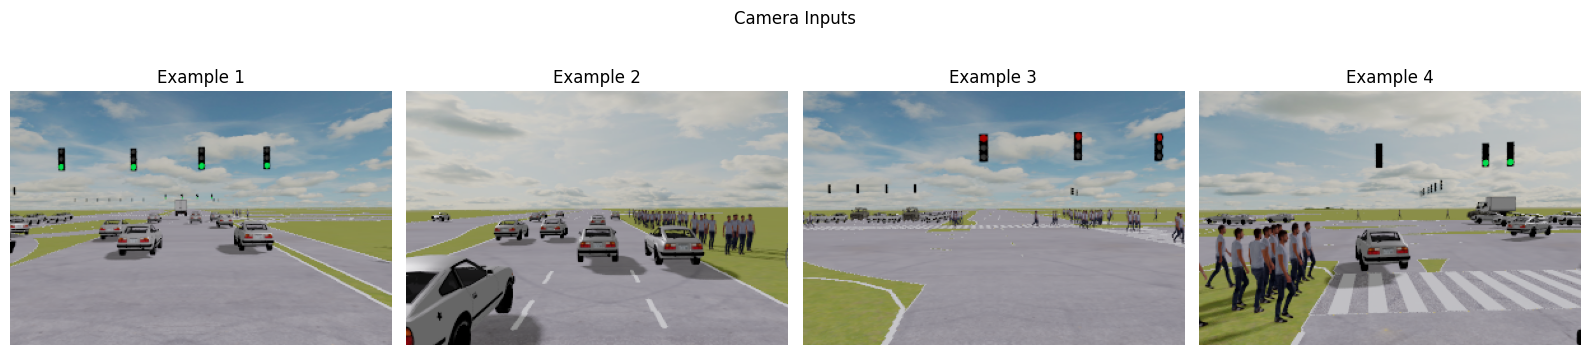

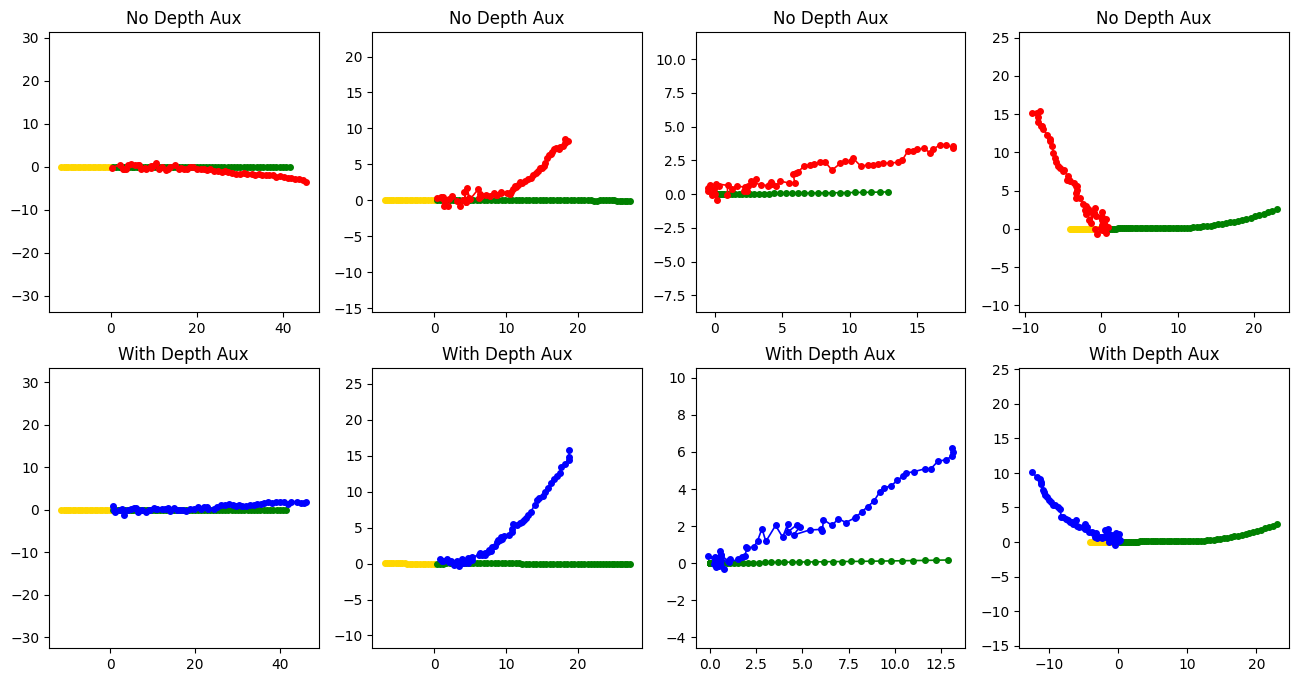

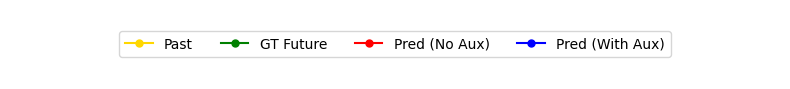

<Figure size 640x480 with 0 Axes>

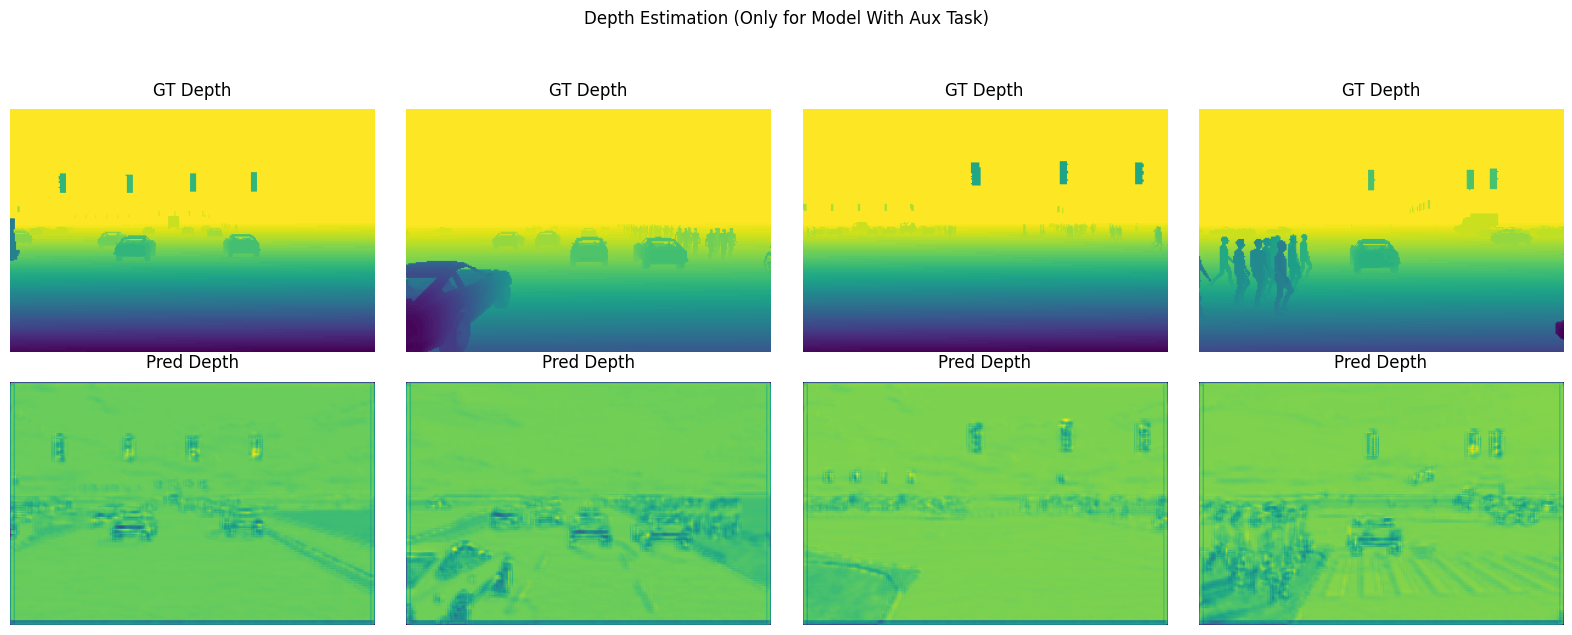

In [13]:
import matplotlib.pyplot as plt
import random

random.seed(40)

def visualize_comparison(val_loader, model_no_aux, model_with_aux, device):
    model_no_aux.eval()
    model_with_aux.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)

    with torch.no_grad():
        pred_no_aux, _ = model_no_aux(camera, history)
        pred_with_aux, pred_depth = model_with_aux(camera, history)

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_no_aux = pred_no_aux.cpu().numpy()
    pred_with_aux = pred_with_aux.cpu().numpy()
    depth = depth.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(2, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        # Without aux
        ax[0, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[0, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[0, i].plot(pred_no_aux[idx, :, 0], pred_no_aux[idx, :, 1], 'o-', label='Pred (No Aux)', color='red', markersize=4, linewidth=1.2)
        ax[0, i].set_title("No Depth Aux")
        ax[0, i].axis("equal")

        # With aux
        ax[1, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[1, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[1, i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], 'o-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[1, i].set_title("With Depth Aux")
        ax[1, i].axis("equal")

    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: Without vs With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Show predicted vs GT depth (only for bottom row)
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, :, :, 0], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            # increase vertical distance between rows

            ax[1, i].imshow(pred_depth[idx, :, :, 0], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")

        plt.suptitle("Depth Estimation (Only for Model With Aux Task)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()


# 🔚 Call at the end after training both models
visualize_comparison(val_loader, model_no_aux, model_with_aux, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called submission_phase2.csv by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [ ]:
with open(os.path.join("data", "phase2", "test_public", "0.pkl"), "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [19]:
import pandas as pd
test_data_dir = os.path.join("data", "phase2", "test_public")
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250)
model_with_aux.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future, _ = model_with_aux(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

file_name = "submission.csv"
# Save to CSV
if not os.path.exists("submission/phase2"):
    os.makedirs("submission/phase2")
df_xy.to_csv(os.path.join("submission", "phase2", file_name), index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
